In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from model import PermutationModel
import numpy as np
import seaborn as sns

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

In [3]:
def compute_grad_norm(p, alpha_max, loss_type, perm_on):
    criterion = loss_type_to_criterion[loss_type]
    one_hot_label = torch.nn.functional.one_hot(label, num_classes=2).type(torch.float32)
    perm_model = PermutationModel(2, label, alpha_max)
    all_pred = torch.stack((p,1-p), dim=1)
    optim = torch.optim.SGD(perm_model.parameters(), lr=1)
    all_grad_norm = []
    for i in range(len(p)):
        prediction = all_pred[i]

        if perm_on == 'pred':
            permuted_logits = perm_model(prediction, label, [0], logits_softmax_mode=None) # try log_perm_softmax
            if loss_type == 'cross_entropy':
                loss = criterion(torch.log(permuted_logits), label)
            elif loss_type == 'kl_divergence':
                loss = criterion(torch.log(permuted_logits), one_hot_label)
            elif loss_type=='L1' or loss_type=='L2':
                loss = criterion(permuted_logits, one_hot_label)
            else:
                raise NotImplementedError
        
        elif perm_on == 'label':
            permuted_label = perm_model(one_hot_label, label, [0], logits_softmax_mode=None) # try log_perm_softmax
            if loss_type == 'cross_entropy':
                raise NotImplemented
                # loss = criterion(torch.log(permuted_logits), label)
            elif loss_type == 'kl_divergence':
                loss = criterion(torch.log(prediction), permuted_label)
            elif loss_type=='L1' or loss_type=='L2':
                loss = criterion(prediction, permuted_label)
            else:
                raise NotImplementedError

        optim.zero_grad()
        loss.backward()
        grad_norm = perm_model.alpha_matrix.grad.norm(p=1)
        all_grad_norm.append(grad_norm)
    all_grad_norm = torch.stack(all_grad_norm)
    return all_grad_norm


In [4]:
def create_single_plot(fig_index, l_type, permutation_on):
    ax[fig_index].set_facecolor('#EBEBEB')
    ax[fig_index].grid(which='major', color='white', linewidth=1.2)
    ax[fig_index].grid(which='minor', color='white', linewidth=0.6)
    ax[fig_index].tick_params('both', length=7, width=1, which='major')
    vertical_line_intercepts = []
    for i, alpha_max in enumerate(alpha_max_list):
        grad_norm_vec = compute_grad_norm(p, alpha_max, l_type, permutation_on)
        ax[fig_index].plot(p, grad_norm_vec, label = r"$\alpha_{1}$ = " + f"{alpha_max}", color=colors[i], linewidth=2.5, zorder=2)
        indx, _ = find_nearest(p, 0.5)
        vertical_line_intercepts.append(grad_norm_vec[indx].clone())
        if permutation_on == 'label':
            ax[fig_index].scatter(0.5, grad_norm_vec[indx], color=grey_color, zorder=4)

    ax[fig_index].set_ylim((0,ax[0].get_ylim()[1]+0.05))
    ax[fig_index].set_xticks(np.linspace(0.0, 1.0, 5))
    # ax[0].set_yticks(np.linspace(0, ax[0].get_ylim()[1], 6))
    ax[fig_index].set_xlim((0,1))
    ax[fig_index].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax[fig_index].grid(zorder=1)
    if permutation_on == 'label':
        ax[fig_index].axvline(x=0.5, ls='--', color=grey_color, linewidth=2, zorder=3, ymax=(max(vertical_line_intercepts).item()-ax[fig_index].get_ylim()[0])/ax[fig_index].get_ylim()[1])

In [5]:
label = torch.tensor([0])
num_bins=1001 
p = torch.linspace(0, 1, steps=num_bins)
loss_type_to_criterion = {
    'cross_entropy': nn.NLLLoss(),
    'L2': nn.MSELoss(),
    'L1': nn.L1Loss(),
    "kl_divergence": nn.KLDivLoss(reduction='batchmean'), ## double check why we need to use reduction='batchmean'
}

In [6]:
colors_rocket = sns.color_palette("rocket",8)
colors = sns.color_palette()
grey_color = sns.color_palette("tab10")[-3]
colors = [colors[0], colors[1], colors[5], colors[1], colors[0]]
# colors


2.1972246170043945
1.0986123085021973
0.0


/Users/salman/Research/noisy_labels/NLLP/model.py:170: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  1, torch.tensor(targets).unsqueeze(1), self.perm_init_value
/Users/salman/miniforge3/envs/torch/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/salman/Research/noisy_labels/NLLP/model.py:170: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  1, torch.tensor(targets).unsqueeze(1), self.perm_init_value
/Users

2.1972246170043945
1.0986123085021973
0.0


/Users/salman/Research/noisy_labels/NLLP/model.py:170: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  1, torch.tensor(targets).unsqueeze(1), self.perm_init_value
/Users/salman/Research/noisy_labels/NLLP/model.py:170: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  1, torch.tensor(targets).unsqueeze(1), self.perm_init_value
/Users/salman/Research/noisy_labels/NLLP/model.py:170: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  1, torch.tensor(targets).unsqueeze(1), self.perm_init_value


2.1972246170043945
1.0986123085021973
0.0


/Users/salman/Research/noisy_labels/NLLP/model.py:170: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  1, torch.tensor(targets).unsqueeze(1), self.perm_init_value
/Users/salman/Research/noisy_labels/NLLP/model.py:170: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  1, torch.tensor(targets).unsqueeze(1), self.perm_init_value
/Users/salman/Research/noisy_labels/NLLP/model.py:170: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  1, torch.tensor(targets).unsqueeze(1), self.perm_init_value


2.1972246170043945
1.0986123085021973
0.0


/Users/salman/Research/noisy_labels/NLLP/model.py:170: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  1, torch.tensor(targets).unsqueeze(1), self.perm_init_value
/Users/salman/Research/noisy_labels/NLLP/model.py:170: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  1, torch.tensor(targets).unsqueeze(1), self.perm_init_value
/Users/salman/Research/noisy_labels/NLLP/model.py:170: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  1, torch.tensor(targets).unsqueeze(1), self.perm_init_value


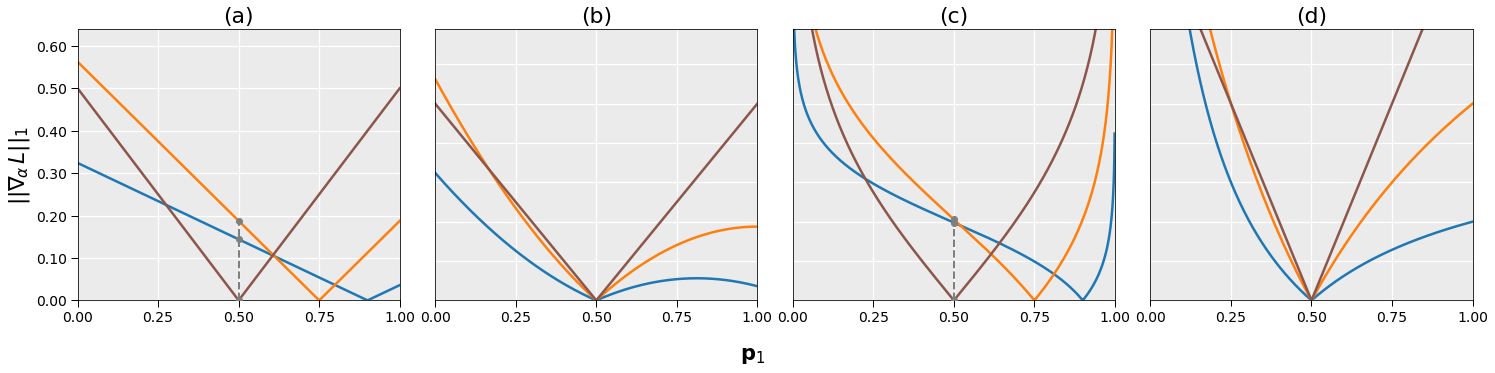

In [7]:
# plt.style.use(['science'])
plt.rcParams['font.size']=14
fig, ax = plt.subplots(1,4, figsize=(25,5))
alpha_max_list = [0.9, 0.75, 0.5]

create_single_plot(0, 'L2', 'label')
create_single_plot(1, 'L2', 'pred')
create_single_plot(2, 'kl_divergence', 'label')
create_single_plot(3, 'kl_divergence', 'pred')



ax[0].set_ylabel(r"$||\nabla_{\!\alpha} \, L||_1$", size=22)


fig.text(0.5, -0.04, "$\mathbf{p}_1$", ha='center', size=21)

ax[1].tick_params(axis='y', which='both', left=False, labelleft=False) # turn off y-ticks
ax[2].tick_params(axis='y', which='both', left=False, labelleft=False) # turn off y-ticks
ax[3].tick_params(axis='y', which='both', left=False, labelleft=False) # turn off y-ticks

ax[0].set_title('(a)', size=22)
ax[1].set_title('(b)', size=22)
ax[2].set_title('(c)', size=22)
ax[3].set_title('(d)', size=22)

plt.subplots_adjust(wspace=0.11)

plt.tick_params(direction='out',which='major', length=6)
plt.savefig('both_l2_legend_in.eps', format='eps', bbox_inches="tight")
plt.savefig('both_l2_legend_in.png', format='png', dpi=600, bbox_inches="tight")


plt.tick_params(direction='out',which='major', length=6)
plt.savefig('perm_on_label_l2.eps', format='eps', bbox_inches="tight")
# plt.legend([r"$\alpha_{max}$ = " + f"{x}" for x in alpha_max_list])